# Final project proposal

https://archive.ics.uci.edu/dataset/336/chronic+kidney+disease

Plan B. 

Null hypothesis: Blood urea will not have any correlation with Chronic Kidney Disease

Alternate Hypothesis: Blood urea will have a correlation with Chronic Kidney Disease

Null: I will individually asses each column on how to deal with nulls, I will explain the logic behind how I dealt with each null value in the project. Basic logic: {categorical: most common categorical value}, {integer or float: mean or median depeding on skew}

Models used: Logisti regression is my first choice, but I will also use trees (and forrest), and maybe SVM 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import seaborn as sns

C:\Users\Admin\AppData\Local\Temp\ipykernel_20964\3502694118.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
df = fetch_ucirepo(id=336)
  
# data (as pandas dataframes) 
x = df.data.features 
y = df.data.targets 
  
x.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,11.3,38.0,6000.0,NaN,no,no,no,good,no,no
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,11.6,35.0,7300.0,4.6,no,no,no,good,no,no


In [3]:
nulls_dict = {'age':[10,42,65,85],'bp':[50,70,78,90],'al':[0,0,2,5],'su':[0,0,0,2],
'bgr':[20,100,150,250],'bu':[9,30,60,120],'sc':[1,3,4,6],'sod':[125,135,140,150],
'pot':[2,4,5,8],'hemo':[5,11,15,18],'pcv':[15,34,44,55],'wbcc':[1000,7000,8500,14500]}

In [4]:
import random

def big_null_deviation_fill(DATAFRAME: pd.DataFrame,DICT:dict) -> pd.DataFrame:
    """"fills the nulls with a random value within the standard deviation ranges
    dict format = 'column':[lower_bound,lower_std,upper_std,upper_std],repeat """

# if float, multiply by 10^n until you have an ints, then process and divide by 10^n
    for i in DICT:
        for w,c in enumerate(DATAFRAME[i].isnull()):
            if c:
                q = random.randint(0,100)
                if q >= 15 and q <= 85:
                    DATAFRAME[i][w] = random.randint(DICT[i][1],DICT[i][2])#/10
                elif q < 15:
                    DATAFRAME[i][w] = random.randint(DICT[i][0],DICT[i][1])#/10
                elif q > 85:
                    DATAFRAME[i][w] = random.randint(DICT[i][2],DICT[i][3])#/10

    return(DATAFRAME)

big_null_deviation_fill(x,nulls_dict)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20964\1449077709.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  DATAFRAME[i][w] = random.randint(DICT[i][0],DICT[i][1])#/10
C:\Users\Admin\AppData\Local\Temp\ipykernel_20964\1449077709.py:15:

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,82.0,...,11.3,38.0,6000.0,NaN,no,no,no,good,no,no
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,11.6,35.0,7300.0,4.6,no,no,no,good,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,15.7,47.0,6700.0,4.9,no,no,no,good,no,no
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,16.5,54.0,7800.0,6.2,no,no,no,good,no,no
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,15.8,49.0,6600.0,5.4,no,no,no,good,no,no
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,14.2,51.0,7200.0,5.9,no,no,no,good,no,no


In [6]:
import random

def small_null_deviation_fill(DATAFRAME, COLUMN: str,LOWER_BOUND:int,LOWER_STD:int,UPPER_STD:int,UPPER_BOUND:int):
    """"fills the nulls with a random value within the standard deviation ranges"""

# if float, multiply by 10^n until you have an ints, then process and divide by 10^n

    for w,c in enumerate(DATAFRAME[COLUMN].isnull()):
        if c:
            q = random.randint(0,100)
            if q > 15 and q < 85:
                DATAFRAME[COLUMN][w] = random.randint(LOWER_STD,UPPER_STD)/10000
            elif q < 15:
                DATAFRAME[COLUMN][w] = random.randint(LOWER_BOUND,LOWER_STD)/10000
            elif q > 85:
                DATAFRAME[COLUMN][w] = random.randint(UPPER_STD,UPPER_BOUND)/10000

    return(DATAFRAME)

small_null_deviation_fill(x,'sg',10050, 10100, 10200, 10250)

C:\Users\Admin\AppData\Local\Temp\ipykernel_16500\181369604.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  DATAFRAME[COLUMN][w] = random.randint(LOWER_STD,UPPER_STD)/10000
C:\Users\Admin\AppData\Local\Temp\ipykernel_16500\181369604.py:

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,107.0,...,11.3,38.0,6000.0,NaN,no,no,no,good,no,no
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,11.6,35.0,7300.0,4.6,no,no,no,good,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,15.7,47.0,6700.0,4.9,no,no,no,good,no,no
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,16.5,54.0,7800.0,6.2,no,no,no,good,no,no
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,15.8,49.0,6600.0,5.4,no,no,no,good,no,no
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,14.2,51.0,7200.0,5.9,no,no,no,good,no,no


In [5]:
import random

def small_null_deviation_fill(DATAFRAME, COLUMN: str,LOWER_BOUND:int,LOWER_STD:int,UPPER_STD:int,UPPER_BOUND:int):
    """"fills the nulls with a random value within the standard deviation ranges"""

# if float, multiply by 10^n until you have an ints, then process and divide by 10^n

    for w,c in enumerate(DATAFRAME[COLUMN].isnull()):
        if c:
            q = random.randint(0,100)
            if q > 15 and q < 85:
                DATAFRAME[COLUMN][w] = random.randint(LOWER_STD,UPPER_STD)/10
            elif q < 15:
                DATAFRAME[COLUMN][w] = random.randint(LOWER_BOUND,LOWER_STD)/10
            elif q > 85:
                DATAFRAME[COLUMN][w] = random.randint(UPPER_STD,UPPER_BOUND)/10

    return(DATAFRAME)

small_null_deviation_fill(x,'rbcc',21, 38, 53, 63)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20964\2469137826.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  DATAFRAME[COLUMN][w] = random.randint(LOWER_BOUND,LOWER_STD)/10
C:\Users\Admin\AppData\Local\Temp\ipykernel_20964\2469137826.py

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,82.0,...,11.3,38.0,6000.0,2.9,no,no,no,good,no,no
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,9.6,31.0,7500.0,4.7,no,yes,no,poor,no,yes
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,11.6,35.0,7300.0,4.6,no,no,no,good,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,15.7,47.0,6700.0,4.9,no,no,no,good,no,no
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,16.5,54.0,7800.0,6.2,no,no,no,good,no,no
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,15.8,49.0,6600.0,5.4,no,no,no,good,no,no
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,14.2,51.0,7200.0,5.9,no,no,no,good,no,no


In [6]:
nb_nulls_dict = {'rbc':'normal','pc':'normal','pcc':'notpresent','ba':'notpresent',
'htn':'no','dm':'no','cad':'no','appet':'good','ane':'no','pe':'no'}

In [7]:
def basic_null_filling(DATAFRAME: pd.DataFrame,NULL_COLUMNS: dict) -> pd.DataFrame:
    """fills in the nulls for all the binary columns"""

    for j in NULL_COLUMNS:
        DATAFRAME[j] = DATAFRAME[j].fillna(NULL_COLUMNS[j])

    return(DATAFRAME)

basic_null_filling(x,nb_nulls_dict)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20964\2903792610.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATAFRAME[j] = DATAFRAME[j].fillna(NULL_COLUMNS[j])


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,normal,normal,notpresent,notpresent,121.0,...,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no
1,7.0,50.0,1.020,4.0,0.0,normal,normal,notpresent,notpresent,82.0,...,11.3,38.0,6000.0,2.9,no,no,no,good,no,no
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,9.6,31.0,7500.0,4.7,no,yes,no,poor,no,yes
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,11.6,35.0,7300.0,4.6,no,no,no,good,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,15.7,47.0,6700.0,4.9,no,no,no,good,no,no
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,16.5,54.0,7800.0,6.2,no,no,no,good,no,no
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,15.8,49.0,6600.0,5.4,no,no,no,good,no,no
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,14.2,51.0,7200.0,5.9,no,no,no,good,no,no


In [8]:
def null_check(DATAFRAME:pd.DataFrame) -> list:

    nulls_list = []

    for i in DATAFRAME:
        for j in DATAFRAME[i].isnull():
            if j:
                if i not in nulls_list:
                    nulls_list.append(i)

    return(nulls_list)

null_check(x)

['sg', 'rbcc']

In [9]:
nb_dict = {'rbc':'abnormal','pc':'abnormal','pcc':'present','ba':'present',
'htn':'yes','dm':'yes','cad':'yes','appet':'poor','ane':'yes','pe':'yes'}


In [10]:
def nb_sort(DATAFRAME: pd.DataFrame,DICT:dict) ->pd.DataFrame:
    """Binary sort a dataframe"""

    for i in DICT:
        nb_sorter = lambda x: 1 if x == DICT[i] else 0

        DATAFRAME[i] = DATAFRAME[i].apply(nb_sorter)

    return(DATAFRAME)

nb_sort(x,nb_dict)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20964\1261725310.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATAFRAME[i] = DATAFRAME[i].apply(nb_sorter)


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,0,0,0,0,121.0,...,15.4,44.0,7800.0,5.2,1,1,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,0,0,0,0,82.0,...,11.3,38.0,6000.0,2.9,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,0,0,0,0,423.0,...,9.6,31.0,7500.0,4.7,0,1,0,1,0,1
3,48.0,70.0,1.005,4.0,0.0,0,1,1,0,117.0,...,11.2,32.0,6700.0,3.9,1,0,0,1,1,1
4,51.0,80.0,1.010,2.0,0.0,0,0,0,0,106.0,...,11.6,35.0,7300.0,4.6,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,0,0,0,0,140.0,...,15.7,47.0,6700.0,4.9,0,0,0,0,0,0
396,42.0,70.0,1.025,0.0,0.0,0,0,0,0,75.0,...,16.5,54.0,7800.0,6.2,0,0,0,0,0,0
397,12.0,80.0,1.020,0.0,0.0,0,0,0,0,100.0,...,15.8,49.0,6600.0,5.4,0,0,0,0,0,0
398,17.0,60.0,1.025,0.0,0.0,0,0,0,0,114.0,...,14.2,51.0,7200.0,5.9,0,0,0,0,0,0


In [11]:
y_nb = {'class':'ckd'}

In [12]:
def nb_sort(DATAFRAME: pd.DataFrame,DICT:dict) ->pd.DataFrame:
    """Binary sort a dataframe"""

    for i in DICT:
        nb_sorter = lambda x: 1 if x == DICT[i] else 0

        DATAFRAME[i] = DATAFRAME[i].apply(nb_sorter)

    return(DATAFRAME)

nb_sort(y,y_nb)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20964\1607186869.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATAFRAME[i] = DATAFRAME[i].apply(nb_sorter)


,class
0,1
1,1
2,1
3,1
4,1
...,...
395,0
396,0
397,0
398,0


# Heatmap

<Axes: >

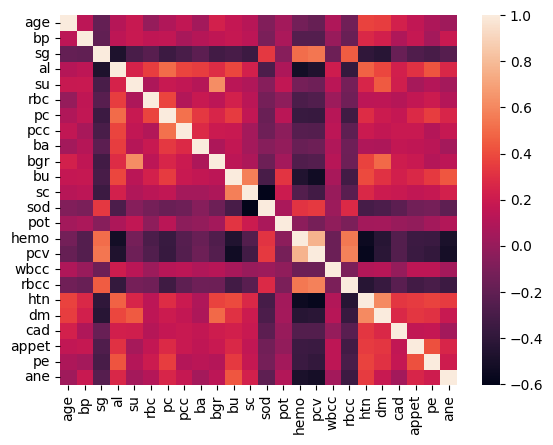

In [13]:
sns.heatmap(x.corr())

# Pie chart

ckd isn't super common so having so many of our outcomes be ckd might tend the model to a false positive

([<matplotlib.patches.Wedge at 0x18f9f279c70>,
 [Text(-0.4049370232742901, 1.0227541284110062, 'ckd'),
  Text(0.40493702327429043, -1.0227541284110062, 'notckd')])

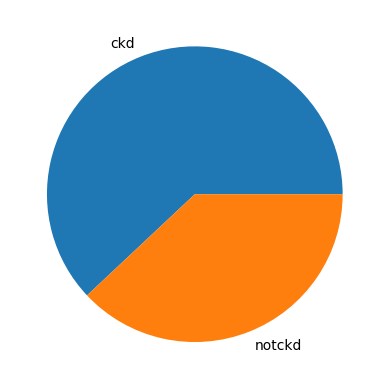

In [305]:
y_values = [248,152]
y_labels = ['ckd','notckd']

plt.pie(y_values,labels=y_labels)

# Age skew

Mostly used data from older people,

might reduce the effectiveness of the model if implemented in clinical settings

Text(0, 0.5, 'age')

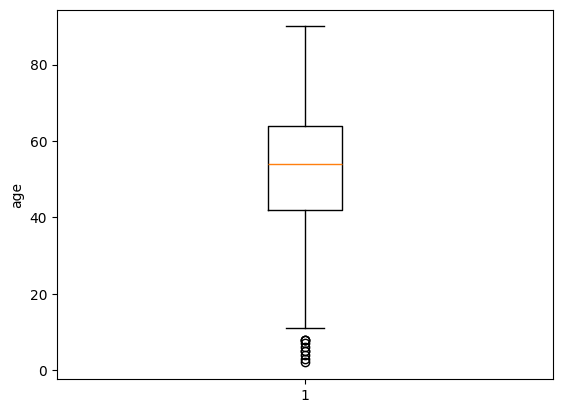

In [15]:
plt.boxplot(x['age'])
plt.ylabel('age')